In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm
import numpy as np
from collections import deque

In [2]:
print(torch.cuda.is_available())  # Should print True if CUDA is available


True


In [3]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 100
# tried training 200 episodes .took more than an hour
#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 195

#device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [4]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):

    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)

        #relu activation
        x = F.relu(x)

        #actions
        actions = self.output_layer(x)

        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs

In [5]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):

    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()

        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

In [6]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''

    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)

    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()

    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    #return action
    return action.item(), m.log_prob(action)
#retunes selected action with its log prbability so it is well managed

In [7]:

# Try to create the LunarLander-v2 environment
try:
    env = gym.make('LunarLander-v2')
    print("Gym environment 'LunarLander-v2' created successfully.")
except Exception as e:
    print(f"Error: {e}")
# Init network
policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)

#Init optimizer
policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.001)
stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=0.001)
print("Environment and Networks Initialized")
print(f"State Space: {env.observation_space.shape[0]} dimensions")
print(f"Action Space: {env.action_space.n} actions")
print(f"Policy Network: {policy_network}")
print(f"State Value Network: {stateval_network}")

Gym environment 'LunarLander-v2' created successfully.
Environment and Networks Initialized
State Space: 8 dimensions
Action Space: 4 actions
Policy Network: PolicyNetwork(
  (input_layer): Linear(in_features=8, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=4, bias=True)
)
State Value Network: StateValueNetwork(
  (input_layer): Linear(in_features=8, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)


In [8]:
scores = []

# Track recent scores
recent_scores = deque(maxlen=100)

# Run episodes
for episode in tqdm(range(NUM_EPISODES)):

    state = env.reset()  # Extract state from the tuple returned by env.reset()
    if isinstance(state, tuple):
        state = state[0]  # Get the state from the tuple
    state = np.array(state)  # Ensure state is a NumPy array
    done = False
    score = 0
    I = 1

    # Run episode, update online
    for step in range(MAX_STEPS):

        # Get action and log probability
        action, lp = select_action(policy_network, state)
        
        # Step with action
        result = env.step(action)

        if len(result) == 4:
            new_state, reward, done, _ = result
        elif len(result) == 5:
            new_state, reward, done, _, _ = result
        else:
            raise ValueError("Unexpected result from env.step()")

        # Update episode score
        score += reward
        
        # Get state value of current state
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_val = stateval_network(state_tensor)
        
        # Get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)
        new_state_val = stateval_network(new_state_tensor)
      
        # If terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)
 
        # Calculate value function loss with MSE
        val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss *= I

        # Calculate policy loss
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -lp * advantage
        policy_loss *= I
       
        # Backpropagate policy
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()

        # Backpropagate value
        stateval_optimizer.zero_grad()
        val_loss.backward()
        stateval_optimizer.step()

        if done:
            break
        # Move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR
    # Append episode score
    scores.append(score)
    recent_scores.append(score)
    
    # Early stopping if we meet solved score goal
    if np.array(recent_scores).mean() >= SOLVED_SCORE:
        break


print("Scores:", scores)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\supri\anaconda3\envs\REINOFRCEMENT\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 100/100 [33:13<00:00, 19.94s/it]  

Scores: [-233.71123593655457, -658.4020946539567, -689.858075566806, -488.8507097196401, -426.0772265078745, -102.16530924964924, -89.98412530489513, -272.8617414744159, -248.57210131473545, -153.52974741131337, -180.8134786880691, -449.4902417260872, -316.3731452303558, -263.46320998475227, -481.38735294842394, -222.52437047641175, -176.97865350979373, -266.24739288094554, -209.97515679843647, -172.19127693330512, -72.30191034383239, -323.3487176262005, -276.2001132278794, -210.2100012126079, -78.79124211053451, -86.78020266841504, -38.15333178658433, -1283.4775448530925, 9.788147944877096, -408.3592978056354, -344.0170631298796, 13.53330256948172, -164.34430556652745, -105.77944162168299, -131.88086522537606, -56.73158413962579, -125.24511927993034, -147.67685584612707, -239.66015091758447, -11.290572710690185, -198.27498915882168, -149.01463996164958, -114.45159403029699, -158.8389613091341, -58.924040831220516, -201.46469373837584, 205.3661146296305, -105.71639286800394, -53.689698

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


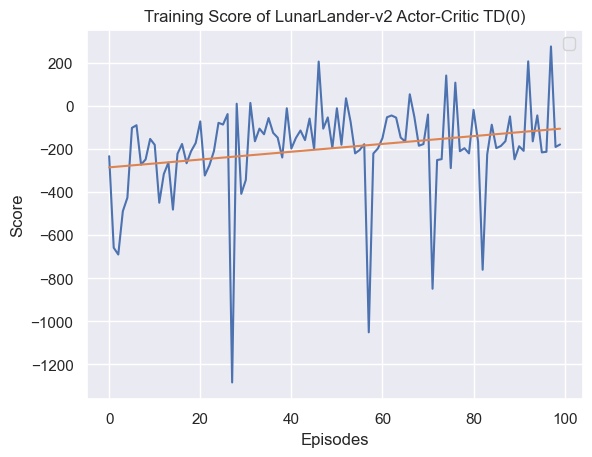

In [9]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('Training Score of LunarLander-v2 Actor-Critic TD(0)')

# Linear regression
reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)

plt.legend()
plt.show()


In [10]:
scores = []

for _ in tqdm(range(20)):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
        
    done = False
    score = 0
    
    while not done:
        action, _ = select_action(policy_network, state)  
        result = env.step(action)
        
        new_state, reward, done, truncated, info = result
        done = done or truncated
        
        if isinstance(new_state, tuple):
            new_state = new_state[0]
        
        score += reward
        state = new_state
    
    scores.append(score)
print(scores)

env.close()


100%|██████████| 20/20 [02:11<00:00,  6.57s/it]

[-190.1076055629264, 157.4235164136792, 162.61498645054684, 28.574951963770076, -15.462281594553218, 201.19707848552952, -21.984102289359953, -80.24131031212792, 69.8639529435286, -16.19934942989812, -181.70870702263602, 89.18568455004271, -219.46199690435043, 50.19341787440715, -187.3835883395314, -36.54633363059124, 64.45558646775996, -188.6508972859421, 20.73567566532013, -66.97899381768624]


In [11]:
env.close()

In [12]:
np.array(scores).mean()

-18.024015768750946